In [1]:
import os
from dotenv import find_dotenv, load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
from pdf2image import convert_from_path
import cv2, os
from fpdf import FPDF

In [3]:
# Store Pdf with convert_from_path function
images = convert_from_path('Original SOF Samples/10.pdf')
 
for i in range(len(images)):
      # Save pages as images in the pdf
    images[i].save('pdf2img/pdf10-page'+ str(i) +'.jpg', 'JPEG')

In [4]:
import boto3
client = boto3.client('textract',region_name='us-east-1',aws_access_key_id='----',aws_secret_access_key='----')

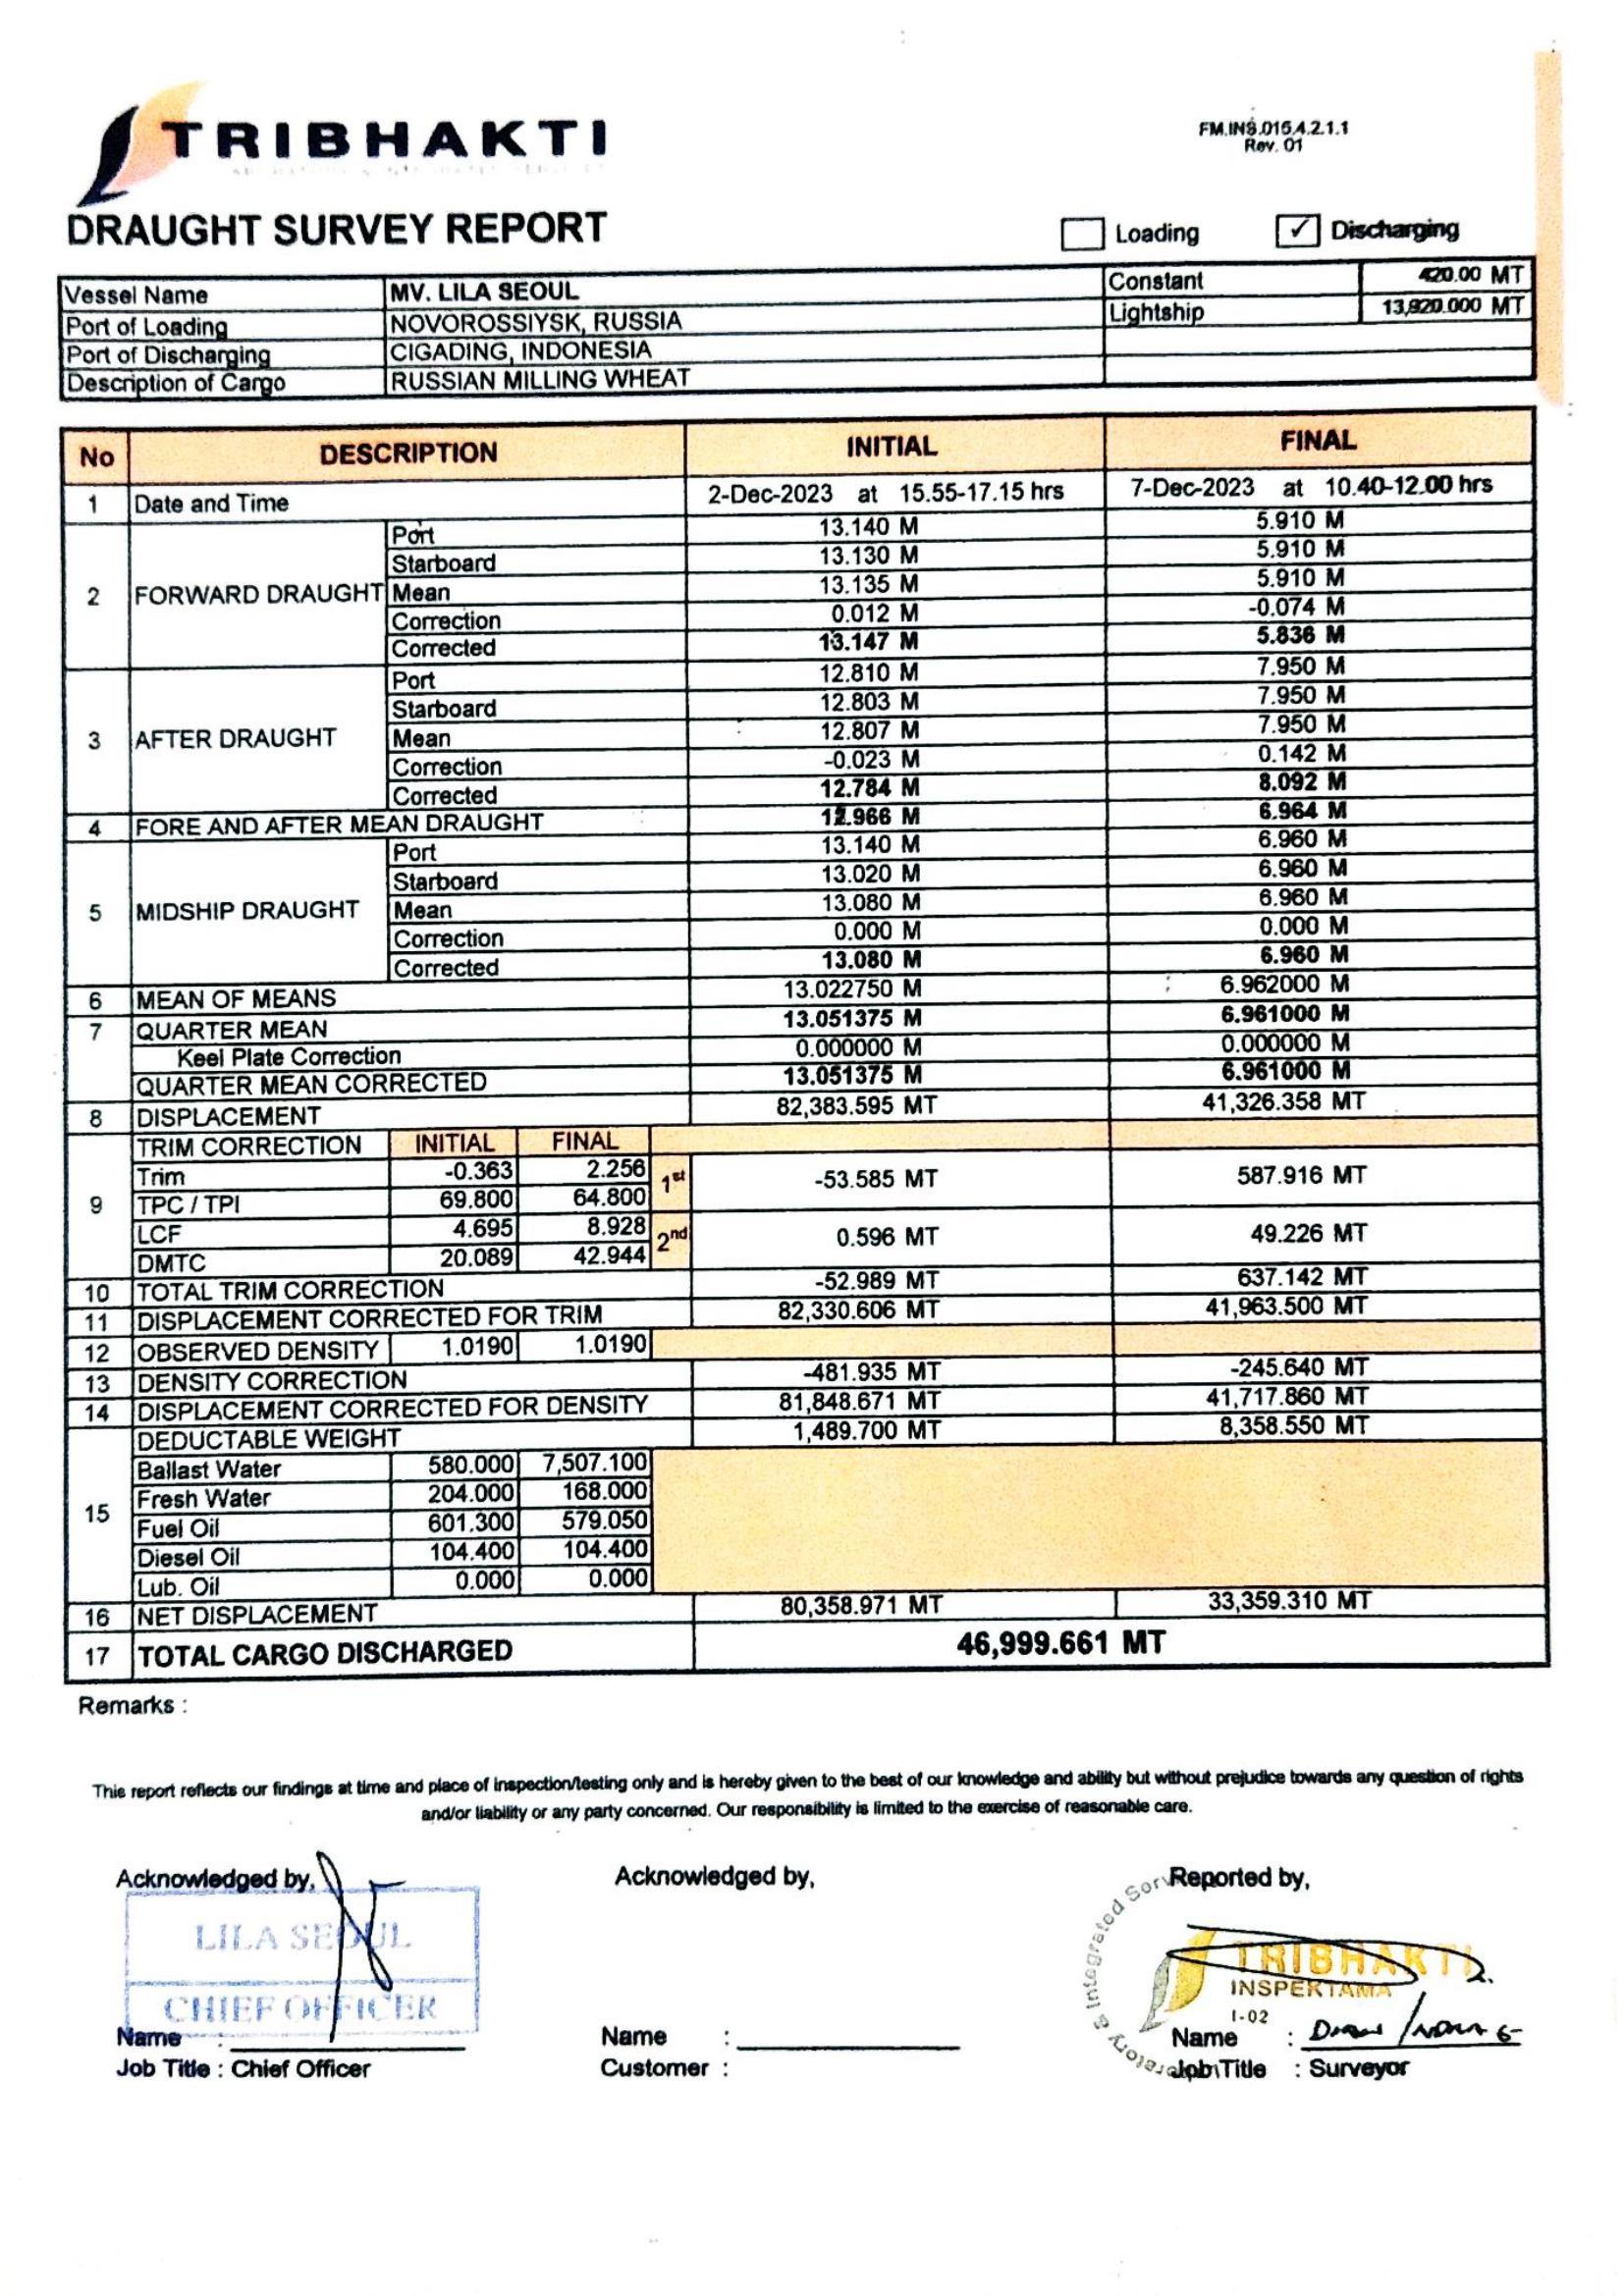

In [5]:
from PIL import Image, ImageDraw
image=Image.open("pdf2img/pdf10-page0.jpg")
# image=Image.open("pdf2img/page0.jpg")
image

In [6]:

with open('pdf2img/pdf10-page0.jpg', 'rb') as image:
    img = bytearray(image.read())

response = client.detect_document_text(
    Document={'Bytes': img}
)

In [7]:
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])
        text = text + " "+item["Text"]

TRIBHAKTI
FM.INS.015.4.2.1.1
Rev. 01
DRAUGHT SURVEY REPORT
Loading
Discharging
MV. LILA SEOUL
Constant
420.00 MT
Vessel Name
Port of Loading
Lightship
13,820.000 MT
NOVOROSSIYSK, RUSSIA
Port of Discharging
CIGADING, INDONESIA
Description of Cargo
RUSSIAN MILLING WHEAT
No
DESCRIPTION
INITIAL
FINAL
1
2-Dec-2023 at 15.55-17.15 hrs
7-Dec-2023 at 10.40-12.00 hrs
Date and Time
13.140 M
5.910 M
Port
Starboard
13.130 M
5.910 M
2
FORWARD DRAUGHT
Mean
13.135 M
5.910 M
Correction
0.012 M
-0.074 M
Corrected
13.147 M
5.836 M
Port
12.810 M
7.950 M
12.803 M
7.950 M
Starboard
3
AFTER DRAUGHT
Mean
12.807 M
7.950 M
Correction
-0.023 M
0.142 M
12.784 M
8.092 M
Corrected
12.966 M
6.964 M
4
FORE AND AFTER MEAN DRAUGHT
Port
13.140 M
6.960 M
Starboard
13.020 M
6.960 M
5
Mean
13.080 M
6.960 M
MIDSHIP DRAUGHT
0.000 M
0.000 M
Correction
Corrected
13.080 M
6.960 M
MEAN OF MEANS
13.022750 M
6.962000 M
6
13.051375 M
6.961000 M
7
QUARTER MEAN
Keel Plate Correction
0.000000 M
0.000000 M
QUARTER MEAN CORRECTED
13.051

In [8]:
with open(f"img2text/aws-tex/pdf10-page{0}.txt", "w") as text_file:
    text_file.write(text)

In [13]:
pdf = FPDF()

for i, text in enumerate(os.listdir("img2text/aws-tex")):
    # Add a page
    pdf.add_page()
    
    # set style and size of font
    # that you want in the pdf
    pdf.set_font("Arial", size = 8)
    
    # open the text file in read mode
    f = open(f"img2text/aws-tex/{text}", "r", encoding="latin-1")
    
    # insert the texts in pdf
    for x in f:
        pdf.cell(180, 5, txt = x, ln = 1, align = 'C')

    f.close()
# save the pdf with name .pdf
pdf.output('new-pdfs/pdf10-tex.pdf', "F")

''

In [19]:
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain.chains import create_extraction_chain, create_extraction_chain_pydantic

from typing import List
import json

llm = ChatOpenAI()

_ = load_dotenv(find_dotenv())

class Document(BaseModel):
    vessel_name: str = Field(description="file order no")
    port_of_loading: str = Field(description="applicant")
    port_of_discharging: str = Field(description="consignment")
    description_of_cargo: str = Field(description="vessel_voyage")
    constant: str = Field(description="port")
    lightship: str = Field(description="nationality flag")
    description: List[str] = Field(description="description")
    total_cargo_discharged: List[str] = Field(description="port of B/L")
    
def load_pdf():
    loader = PyPDFLoader("new-pdfs/pdf10-tex.pdf")
    pages = loader.load()
    return pages

def extract_metadata_from_pdf_output_parser():
    pages = load_pdf()
    
    parser = JsonOutputParser(pydantic_object=Document)
    
    prompt = PromptTemplate(
        template="Extract the information as specified.\n{format_instructions}\n{context}\n",
        input_variables=["context"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({
        "context": pages
    })

    print("Function: extract_metadata_from_pdf_output_parser")
    with open('pdf2json/pdf10-tex.json', 'w', encoding='utf-8') as f:
        json.dump(response, f, ensure_ascii=False, indent=4)
    print(response)
    
def extract_metadata_from_pdf_extraction_chain():
    pages = load_pdf()
    
    schema = {
    "properties": {
        "vessel_name": {"type": "string"},
        "port_of_loading": {"type": "string"},
        "port_of_discharging": {"type": "string"},
        "description_of_cargo": {"type": "string"},
        "constant": {"type": "string"},
        "lightship": {"type": "string"},
        "description": {"type": "array", "items": {"type": "string"}},
        "total_cargo_discharged": {"type": "string"}
    },

    "required": ["vessel name", "port of loading", "port of discharging", "discription of cargo", "constant", "lightship", "description inital final", "total cargo discharged"]
    }
    
    chain = create_extraction_chain(schema, llm)

    response = chain.run(pages)
    
    print(response)
    
def extract_metadata_from_pdf_extraction_chain_pydantic():
    pages = load_pdf()

    chain = create_extraction_chain_pydantic(Document, llm)

    response = chain.run(pages)
    
    print("before")
    with open('data.json', 'w', encoding='utf-8') as f:
        json.dump(response, f, ensure_ascii=False, indent=4)
        print("here")
    print(response)
    
extract_metadata_from_pdf_output_parser()

Function: extract_metadata_from_pdf_output_parser
{'vessel_name': 'MV. LILA SEOUL', 'port_of_loading': 'NOVOROSSIYSK, RUSSIA', 'port_of_discharging': 'CIGADING, INDONESIA', 'description_of_cargo': 'RUSSIAN MILLING WHEAT', 'constant': '420.00 MT', 'lightship': '13,820.000 MT', 'description': ['DESCRIPTION INITIAL FINAL', '1 2-Dec-2023 at 15.55-17.15 hrs 7-Dec-2023 at 10.40-12.00 hrs', 'Date and Time', '13.140 M 5.910 M Port Starboard', '13.130 M 5.910 M', '2 FORWARD DRAUGHT Mean 13.135 M 5.910 M Correction 0.012 M -0.074 M Corrected 13.147 M 5.836 M Port 12.810 M 7.950 M 12.803 M 7.950 M Starboard', '3 AFTER DRAUGHT Mean 12.807 M 7.950 M Correction -0.023 M 0.142 M 12.784 M 8.092 M Corrected 12.966 M 6.964 M', '4 FORE AND AFTER MEAN DRAUGHT Port 13.140 M 6.960 M Starboard 13.020 M 6.960 M Mean 13.080 M 6.960 M MIDSHIP DRAUGHT 0.000 M 0.000 M Correction Corrected 13.080 M 6.960 M MEAN OF MEANS 13.022750 M 6.962000 M 13.051375 M 6.961000 M QUARTER MEAN Keel Plate Correction 0.000000 M 0.0